In [22]:
# importation de quelques librairies

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
import pickle

from dotenv import load_dotenv
import os

load_dotenv()

True

In [59]:
# variable pour entrainer les modèles catboost et réseau de neurones

train_model = True

In [24]:
# chemin de nos données d'entrainement et de test

train_path = os.getenv('WINE_TRAIN_PATH')
test_path = os.getenv('WINE_TEST_PATH')

# chargement des données

df_train = pd.read_csv(train_path).drop('wine_ID', axis=1)
df_test = pd.read_csv(test_path)

## Analyse des données

In [25]:
# visualisation des données

df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type,target
0,7.2,0.16,0.26,7.1,0.054,41.0,224.0,0.99660,3.38,0.55,10.1,0,5
1,7.3,0.22,0.31,2.3,0.018,45.0,80.0,0.98936,3.06,0.34,12.9,0,7
2,8.9,0.13,0.49,1.0,0.028,6.0,24.0,0.99260,2.91,0.32,9.9,0,5
3,6.0,0.17,0.29,9.7,0.044,33.0,98.0,0.99536,3.12,0.36,9.2,0,6
4,7.5,0.19,0.34,2.6,0.037,33.0,125.0,0.99230,3.10,0.49,11.1,0,7


In [26]:
# informations sur les données

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4547 entries, 0 to 4546
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4547 non-null   float64
 1   volatile acidity      4547 non-null   float64
 2   citric acid           4547 non-null   float64
 3   residual sugar        4547 non-null   float64
 4   chlorides             4547 non-null   float64
 5   free sulfur dioxide   4547 non-null   float64
 6   total sulfur dioxide  4547 non-null   float64
 7   density               4547 non-null   float64
 8   pH                    4547 non-null   float64
 9   sulphates             4547 non-null   float64
 10  alcohol               4547 non-null   float64
 11  wine_type             4547 non-null   int64  
 12  target                4547 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 461.9 KB


In [27]:
# description des données

df_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,wine_type,target
count,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000,4547.000000
mean,7.235364,0.340110,0.318155,5.367572,0.056112,30.364416,115.502309,0.994700,3.219477,0.533006,10.496162,0.249835,5.824060
std,1.319966,0.166643,0.142942,4.748314,0.035236,17.868751,56.989343,0.003015,0.163511,0.150728,1.179564,0.432965,0.876346
min,3.800000,0.080000,0.000000,0.600000,0.012000,1.000000,6.000000,0.987130,2.740000,0.220000,8.000000,0.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,0.000000,5.000000
50%,7.000000,0.290000,0.310000,2.900000,0.047000,29.000000,118.000000,0.994800,3.210000,0.510000,10.300000,0.000000,6.000000
75%,7.700000,0.400000,0.390000,8.000000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,0.000000,6.000000
max,15.600000,1.580000,1.000000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.200000,1.000000,9.000000


In [28]:
# forme des données

print(df_train.shape, df_test.shape)

(4547, 13) (1950, 13)


<module 'matplotlib.pyplot' from '/Users/samy/anaconda3/lib/python3.11/site-packages/matplotlib/pyplot.py'>

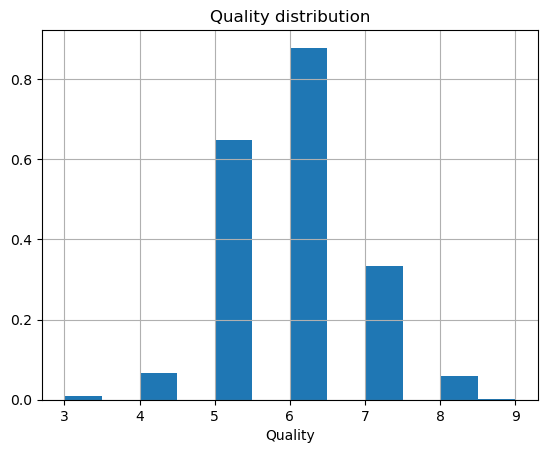

In [29]:
# Disrtibution des classes

df_train['target'].hist(bins=12, density=True)
plt.title('Quality distribution')
plt.xlabel('Quality')
plt

Text(0.5, 1.0, 'Correlation Matrix')

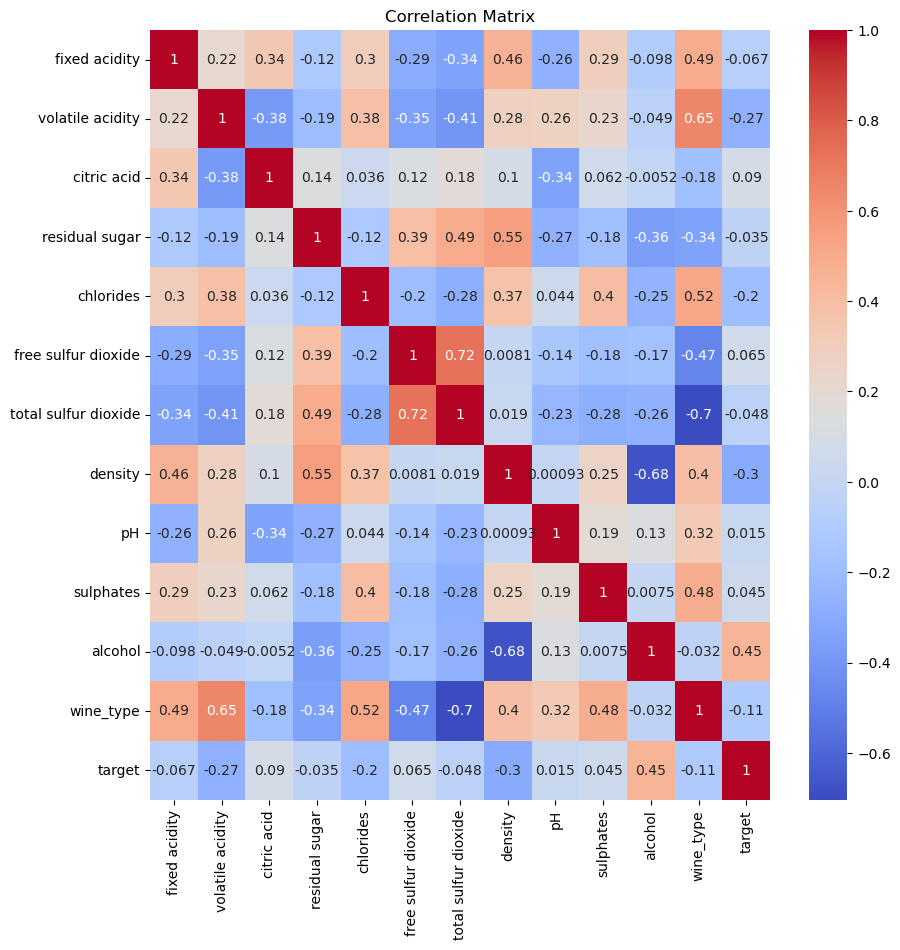

In [30]:
# Matrice de corrélation

plt.figure(figsize=(10, 10))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')

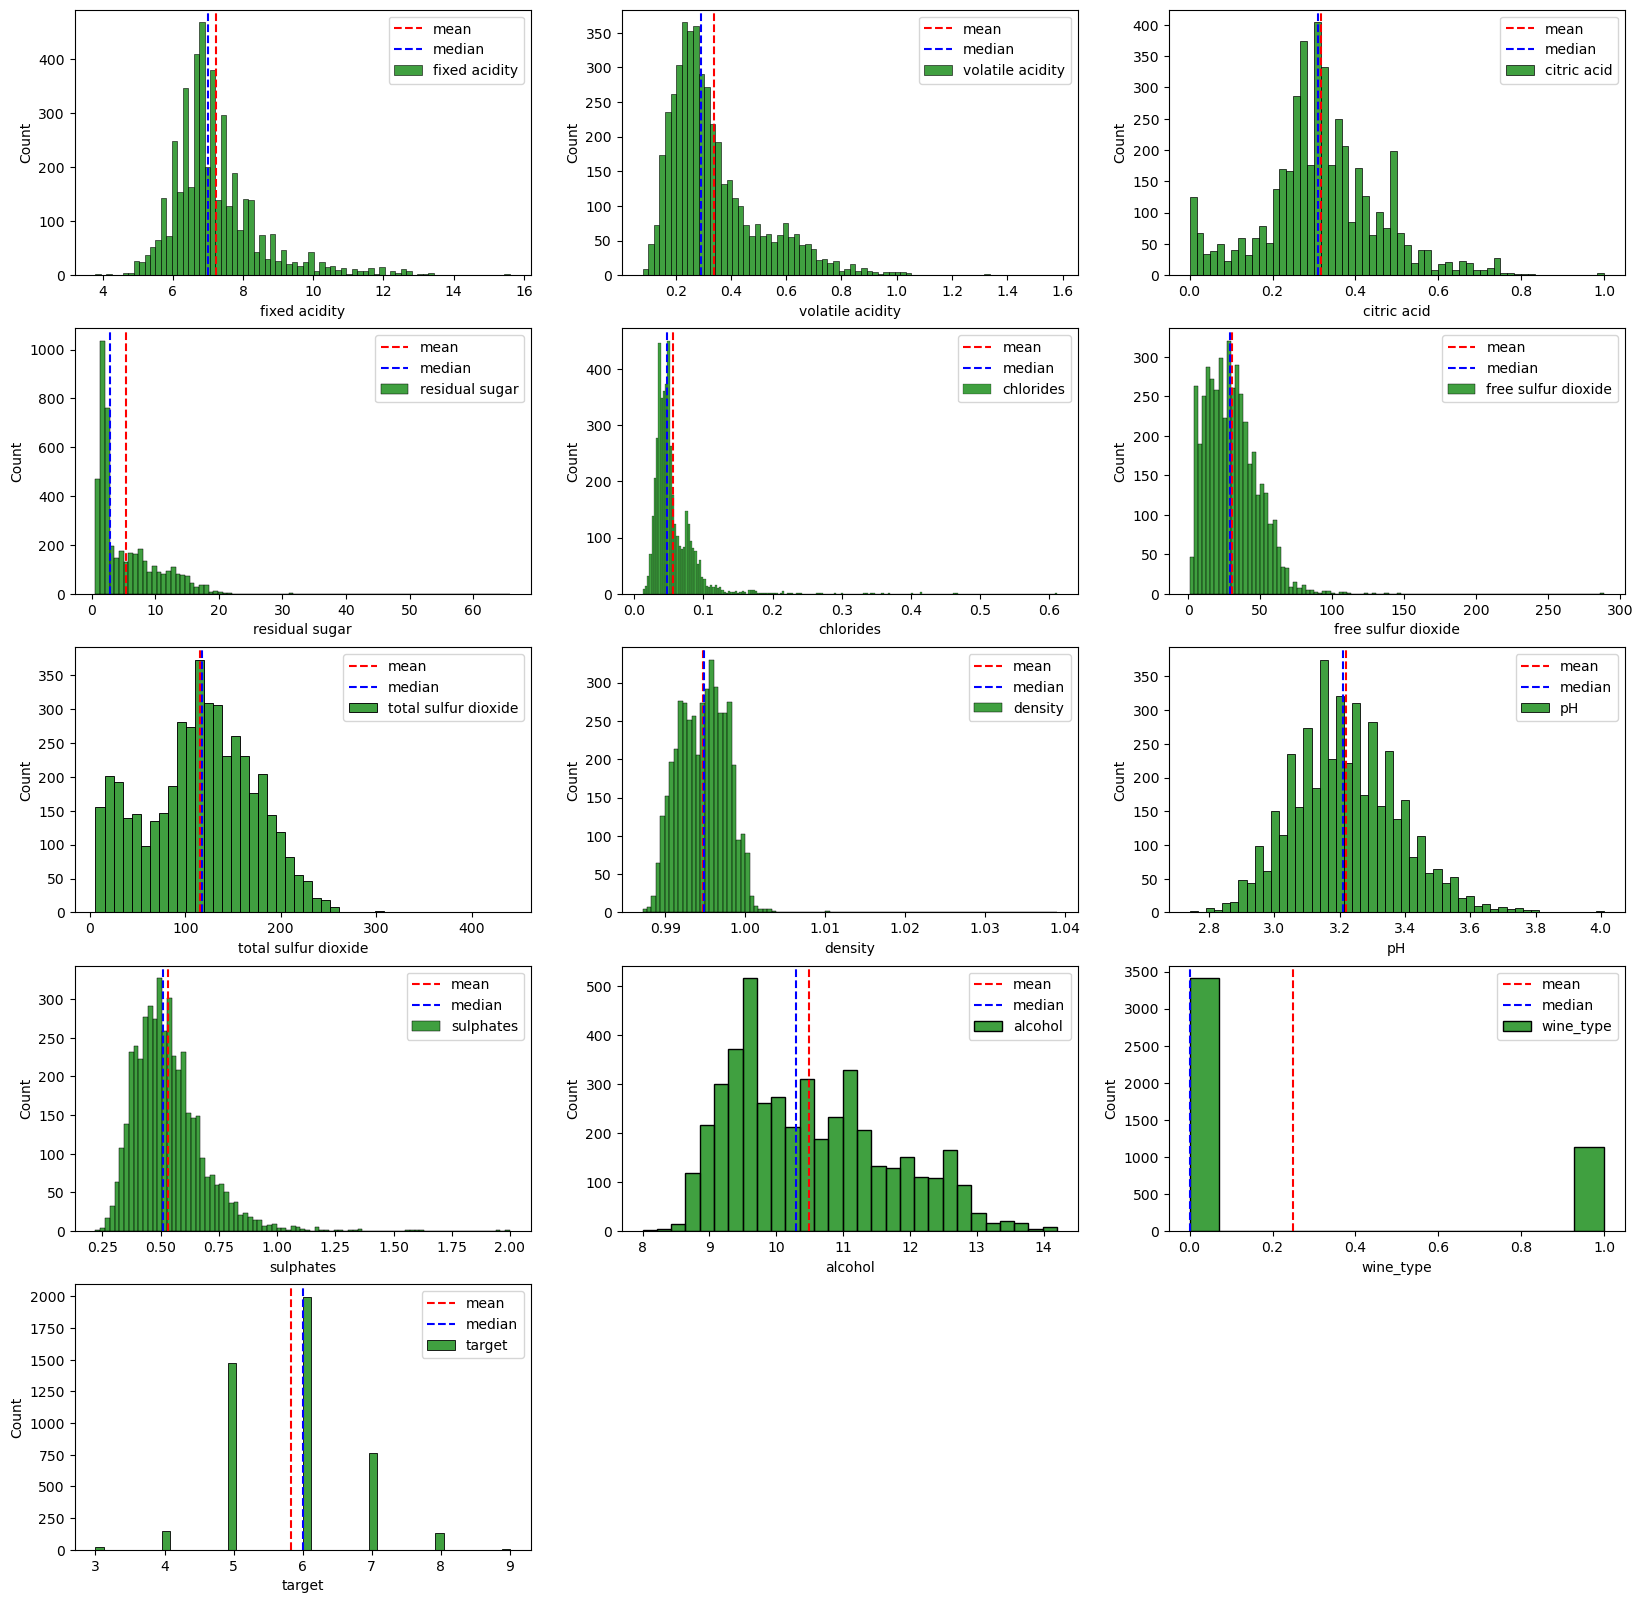

In [31]:
# Distribution des variables

fig = plt.figure(figsize=(20, 20))
for i in range(len(df_train.columns)):
    fig.add_subplot(5, 3, i+1)
    sns.histplot(df_train.iloc[:, i], color='green', label=df_train.columns[i])
    # show the mean and median
    plt.axvline(df_train.iloc[:, i].mean(), linestyle='dashed', color='red', label='mean')
    plt.axvline(df_train.iloc[:, i].median(), linestyle='dashed', color='blue', label='median')
    plt.legend()

## Séparation train-test

In [33]:
# Séparation des données en train test

X = df_train.drop('target', axis=1)
y = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

## Linear Regression

In [34]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

# Entrainement du modèle

model.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f"Le r2 vaut : {r2_score(y_test, y_preds)}")

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/linear_regression.csv', index=False)

# soumission des résultats

model = LinearRegression()

model.fit(X, y)

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/linear_regression.csv', index=False)



Le r2 vaut : 0.311967248929242


## CatBoost Regressor

In [35]:
from catboost import CatBoostRegressor

# Entrainement du modèle

if train_model:

    model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=0)

    pickle.dump(model, open('../models/regression/catboost.pkl', 'wb'))

else:
    model = pickle.load(open('../models/regression/catboost.pkl', 'rb'))

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/catboost.csv', index=False)

# soumission des résultats

if train_model:

    model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

    model.fit(X, y, verbose=0)

    pickle.dump(model, open('../models/regression/catboost_complet.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/catboost_complet.pkl', 'rb'))

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/catboost.csv', index=False)

Le r2 vaut : 0.4904617814714384


## Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

# Définition de notre espaces de paramètres

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

model = RandomForestRegressor(random_state=42)

if best_params is None:

    params = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [1, 2, 5, 10, 15]}


    # Création de notre grille de recherche

    grid = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1)

    # Entrainement de notre modèle

    grid.fit(X_train, y_train)

    # Affichage des meilleurs paramètres

    print(grid.best_params_)
    print(grid.best_score_)

    best_params = grid.best_params_

model.set_params(**best_params)

# Entrainement du modèle

model.fit(X_train, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/random_forest.csv', index=False)

# soumission des résultats

model = RandomForestRegressor(random_state=42)
model.set_params(**best_params)

model.fit(X, y)

y_preds = model.predict(df_test.drop('wine_ID', axis=1))

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/random_forest.csv', index=False)

Le r2 vaut : 0.4925929105861855


## Neural Network

In [37]:
trainset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
testset = TensorDataset(torch.tensor(X_test.values, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

fullset = TensorDataset(torch.tensor(X.values, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
fullloader = DataLoader(fullset, batch_size=32, shuffle=True)

full_testset = TensorDataset(torch.tensor(df_test.drop('wine_ID', axis=1).values, dtype=torch.float32))

In [38]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        super(NeuralNetworkRegressor, self).__init__()
        self.fc1 = nn.Linear(12, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [60]:
if train_model:

    model = NeuralNetworkRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

        with torch.no_grad():
            model.eval()
            y_preds = []
            for inputs, labels in testset:
                outputs = model(inputs)
                y_preds.append(outputs.item())
        print(f"r2 : {r2_score(y_test, y_preds)}")

    pickle.dump(model, open('../models/regression/neural_network.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/neural_network.pkl', 'rb'))

model.eval()

y_preds = []

for inputs, labels in testset:
    outputs = model(inputs)
    y_preds.append(outputs.item())
    

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

print(f"r2 : {r2_score(y_test, y_preds)}")

# new_results.to_csv('../résultats_models/regression/neural_network.csv', index=False)

r2 : 0.35343043720959666


In [63]:
if train_model:

    model = NeuralNetworkRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in fullloader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

        print(f"for epoch {epoch} : {running_loss / len(trainloader)}")

    with torch.no_grad():
        model.eval()
        y_preds = []
        for inputs in full_testset:
            outputs = model(inputs[0])
            y_preds.append(outputs.item())

    pickle.dump(model, open('../models/regression/neural_network_complet.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/neural_network_complet.pkl', 'rb'))

model.eval()

y_preds = []

for inputs in full_testset:
    outputs = model(inputs[0])
    y_preds.append(outputs.item())

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/neural_network.csv', index=False)

## Normalisation des données

In [64]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_train_scaled = scaler.fit_transform(df_train.drop('target', axis=1))
df_test_scaled = scaler.transform(df_test.drop('wine_ID', axis=1))

## Linear Regression

In [65]:
model = LinearRegression()

# Entrainement du modèle

model.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)

# Evaluation du modèle

print(f"Le r2 vaut : {r2_score(y_test, y_preds)}")

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/linear_regression_scaled.csv', index=False)

# soumission des résultats

model = LinearRegression()

model.fit(df_train_scaled, y)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/linear_regression_scaled.csv', index=False)

Le r2 vaut : 0.31196724892924665


## CatBoost Regressor

In [67]:
if train_model:

    model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

    # Entrainement du modèle

    model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), verbose=0)

    pickle.dump(model, open('../models/regression/catboost_scaled.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/catboost_scaled.pkl', 'rb'))

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/catboost_scaled.csv', index=False)

# soumission des résultats

if train_model:

    model = CatBoostRegressor(iterations=10000, depth=10, learning_rate=0.1, loss_function='RMSE', eval_metric='R2', random_seed=42)

    model.fit(df_train_scaled, y, verbose=0)

    pickle.dump(model, open('../models/regression/catboost_scaled_complet.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/catboost_scaled_complet.pkl', 'rb'))

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/catboost_scaled.csv', index=False)

Le r2 vaut : 0.48997444203007434


## Random Forest Regressor

In [22]:
model = RandomForestRegressor(random_state=42)

best_params = {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}

if best_params is None:

    # Définition de notre espaces de paramètres

    params = {'n_estimators': [100, 200, 300, 400, 500],
                'max_depth': [5, 10, 15, 20, 25],
                'min_samples_split': [2, 5, 10, 15, 20],
                'min_samples_leaf': [1, 2, 5, 10, 15]}

    # Création de notre grille de recherche

    grid = GridSearchCV(model, params, cv=5, scoring='r2', n_jobs=-1)

    # Entrainement de notre modèle

    grid.fit(X_train_scaled, y_train)

    # Affichage des meilleurs paramètres

    print(grid.best_params_)
    print(grid.best_score_)

    best_params = grid.best_params_

model.set_params(**best_params)

# Entrainement du modèle

model.fit(X_train_scaled, y_train)

# Prédiction sur les données de test

y_preds = model.predict(X_test_scaled)


# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')

# Sauvegarde des résultats pour streamlit

new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/random_forest_scaled.csv', index=False)

# soumission des résultats

model = RandomForestRegressor(random_state=42)
model.set_params(**grid.best_params_)

model.fit(df_train_scaled, y)

y_preds = model.predict(df_test_scaled)

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/random_forest_scaled.csv', index=False)

{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
0.42768376070072484
Le r2 vaut : 0.49457656248378246


In [68]:
trainset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
testset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

fullset = TensorDataset(torch.tensor(df_train_scaled, dtype=torch.float32), torch.tensor(y.values, dtype=torch.float32))
fullloader = DataLoader(fullset, batch_size=32, shuffle=True)

full_testset = TensorDataset(torch.tensor(df_test_scaled, dtype=torch.float32))

In [69]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        super(NeuralNetworkRegressor, self).__init__()
        self.fc1 = nn.Linear(12, 6)
        self.fc2 = nn.Linear(6, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [73]:
if train_model:

    model = NeuralNetworkRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in trainloader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

        with torch.no_grad():
            model.eval()
            y_preds = []
            for inputs, labels in testset:
                outputs = model(inputs)
                y_preds.append(outputs.item())
        print(f"r2 : {r2_score(y_test, y_preds)}")

    pickle.dump(model, open('../models/regression/neural_network_scaled.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/neural_network_scaled.pkl', 'rb'))

y_preds = []
with torch.no_grad():
    model.eval()
    for inputs in testset:
        outputs = model(inputs[0])
        y_preds.append(outputs.item())

# Evaluation du modèle

print(f'Le r2 vaut : {r2_score(y_test, y_preds)}')


new_results = pd.DataFrame({'y_test': y_test,
                            'y_preds': y_preds})

# new_results.to_csv('../résultats_models/regression/neural_network_scaled.csv', index=False)

Le r2 vaut : 0.36841639411476346


In [75]:
if train_model:

    model = NeuralNetworkRegressor()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 1000

    for epoch in range(epochs):
        running_loss = 0
        for inputs, labels in fullloader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        else:
            test_loss = 0
            accuracy = 0

        print(f"for epoch {epoch} : {running_loss / len(trainloader)}")

    with torch.no_grad():
        model.eval()
        y_preds = []
        for inputs in full_testset:
            outputs = model(inputs[0])
            y_preds.append(outputs.item())

    pickle.dump(model, open('../models/regression/neural_network_scaled_complet.pkl', 'wb'))

else:

    model = pickle.load(open('../models/regression/neural_network_scaled_complet.pkl', 'rb'))

y_preds = []
with torch.no_grad():
    model.eval()
    for inputs in full_testset:
        outputs = model(inputs[0])
        y_preds.append(outputs.item())

submission = pd.DataFrame({'wine_ID': df_test['wine_ID'],
                            'target': y_preds})

# submission.to_csv('../soumission/regression/neural_network_scaled.csv', index=False)